<a href="https://colab.research.google.com/github/Yonasafom/DeepLearningSpecialization-/blob/main/IBM_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

In [ ]:
!git clone https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks.git

In [4]:
cd RE-ParameterizedExplainerForGraphNeuralNetworks/

/content/RE-ParameterizedExplainerForGraphNeuralNetworks


In [5]:
import torch
import torch
from torch.nn import ReLU, Linear
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool
from ExplanationEvaluation.configs.selector import Selector
from ExplanationEvaluation.tasks.replication import replication
from ExplanationEvaluation.tasks.replication import run_experiment

from ExplanationEvaluation.evaluation.EfficiencyEvaluation import EfficiencyEvluation
from ExplanationEvaluation.tasks.replication import select_explainer
from ExplanationEvaluation.tasks.replication import get_classification_task
from ExplanationEvaluation.models.model_selector import model_selector
from ExplanationEvaluation.datasets.ground_truth_loaders import load_dataset_ground_truth
from ExplanationEvaluation.datasets.dataset_loaders import load_dataset
from ExplanationEvaluation.evaluation.AUCEvaluation import AUCEvaluation
from ExplanationEvaluation.datasets.dataset_loaders import load_dataset

#Model

In [6]:
# node and graph classification 

import torch
import os
from torch.nn import ReLU, Linear
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool


class NodeGCN(torch.nn.Module):
    """
    A graph clasification model for nodes decribed in https://arxiv.org/abs/1903.03894.
    This model consists of 3 stacked GCN layers followed by a linear layer.
    """
    def __init__(self, num_features, num_classes):
        super(NodeGCN, self).__init__()
        self.embedding_size = 20 * 3
        self.conv1 = GCNConv(num_features, 20)
        self.relu1 = ReLU()
        self.conv2 = GCNConv(20, 20)
        self.relu2 = ReLU()
        self.conv3 = GCNConv(20, 20)
        self.relu3 = ReLU()
        self.lin = Linear(3*20, num_classes)

    def forward(self, x, edge_index, edge_weights=None):
        input_lin = self.embedding(x, edge_index, edge_weights)
        final = self.lin(input_lin)
        return final

    def embedding(self, x, edge_index, edge_weights=None):
        if edge_weights is None:
            edge_weights = torch.ones(edge_index.size(1))
        stack = []

        out1 = self.conv1(x, edge_index, edge_weights)
        out1 = torch.nn.functional.normalize(out1, p=2, dim=1)  # this is not used in PGExplainer
        out1 = self.relu1(out1)
        stack.append(out1)

        out2 = self.conv2(out1, edge_index, edge_weights)
        out2 = torch.nn.functional.normalize(out2, p=2, dim=1)  # this is not used in PGExplainer
        out2 = self.relu2(out2)
        stack.append(out2)

        out3 = self.conv3(out2, edge_index, edge_weights)
        out3 = torch.nn.functional.normalize(out3, p=2, dim=1)  # this is not used in PGExplainer
        out3 = self.relu3(out3)
        stack.append(out3)

        input_lin = torch.cat(stack, dim=1)

        return input_lin

class GraphGCN(torch.nn.Module):
    """
    A graph clasification model for graphs decribed in https://arxiv.org/abs/1903.03894.
    This model consists of 3 stacked GCN layers followed by a linear layer.
    In between the GCN outputs and linear layers are pooling operations in both mean and max.
    """
    def __init__(self, num_features, num_classes):
        super(GraphGCN, self).__init__()
        self.embedding_size = 20
        self.conv1 = GCNConv(num_features, 20)
        self.relu1 = ReLU()
        self.conv2 = GCNConv(20, 20)
        self.relu2 = ReLU()
        self.conv3 = GCNConv(20, 20)
        self.relu3 = ReLU()
        self.lin = Linear(self.embedding_size * 2, num_classes)

    def forward(self, x, edge_index, batch=None, edge_weights=None):
        if batch is None: # No batch given
            batch = torch.zeros(x.size(0), dtype=torch.long)
        embed = self.embedding(x, edge_index, edge_weights)

        out1 = global_max_pool(embed, batch)
        out2 = global_mean_pool(embed, batch)
        input_lin = torch.cat([out1, out2], dim=-1)

        out = self.lin(input_lin)
        return out

    def embedding(self, x, edge_index, edge_weights=None):
        if edge_weights is None:
            edge_weights = torch.ones(edge_index.size(1))
        stack = []

        out1 = self.conv1(x, edge_index, edge_weights)
        out1 = torch.nn.functional.normalize(out1, p=2, dim=1)
        out1 = self.relu1(out1)
        stack.append(out1)

        out2 = self.conv2(out1, edge_index, edge_weights)
        out2 = torch.nn.functional.normalize(out2, p=2, dim=1)
        out2 = self.relu2(out2)
        stack.append(out2)

        out3 = self.conv3(out2, edge_index, edge_weights)
        out3 = torch.nn.functional.normalize(out3, p=2, dim=1)
        out3 = self.relu3(out3)

        input_lin = out3

        return input_lin


In [7]:
_dataset = 'bashapes' # One of: bashapes, bacommunity, treecycles, treegrids, ba2motifs, mutag

# Parameters below should only be changed if you want to run any of the experiments in the supplementary
_folder = 'replication' # One of: replication, batchnorm
_model = 'gnn' #if _folder == 'replication' else 'ori'

# PGExplainer
config_path = f"./ExplanationEvaluation/configs/{_folder}/models/model_{_model}_{_dataset}.json"
print(config_path)

config = Selector(config_path).args

extension = (_folder == 'extension')

./ExplanationEvaluation/configs/replication/models/model_gnn_bashapes.json


In [8]:
def train_node(_dataset, _paper, args):
    """
    Train a explainer to explain node classifications
    :param _dataset: the dataset we wish to use for training
    :param _paper: the paper we whish to follow, chose from "GNN" or "PG"
    :param args: a dict containing the relevant model arguements
    """
    graph, features, labels, train_mask, val_mask, test_mask = load_dataset(_dataset)
    model = model_selector(_paper, _dataset, False)

    x = torch.tensor(features)
    edge_index = torch.tensor(graph)
    labels = torch.tensor(labels)

    # Define graph
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(0, args.epochs):
        model.train()
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_max)
        optimizer.step()

        if args.eval_enabled: model.eval()
        with torch.no_grad():
            out = model(x, edge_index)

        # Evaluate train
        train_acc = evaluate(out[train_mask], labels[train_mask])
        test_acc = evaluate(out[test_mask], labels[test_mask])
        val_acc = evaluate(out[val_mask], labels[val_mask])

        print(f"Epoch: {epoch}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, train_loss: {loss:.4f}")

        if val_acc > best_val_acc: # New best results
            print("Val improved")
            best_val_acc = val_acc
            best_epoch = epoch
            store_checkpoint(_paper, _dataset, model, train_acc, val_acc, test_acc, best_epoch)

        if epoch - best_epoch > args.early_stopping and best_val_acc > 0.99:
            break

    model = load_best_model(best_epoch, _paper, _dataset, model, args.eval_enabled)
    out = model(x, edge_index)

    # Train eval
    train_acc = evaluate(out[train_mask], labels[train_mask])
    test_acc = evaluate(out[test_mask], labels[test_mask])
    val_acc = evaluate(out[val_mask], labels[val_mask])
    print(f"final train_acc:{train_acc}, val_acc: {val_acc}, test_acc: {test_acc}")

    store_checkpoint(_paper, _dataset, model, train_acc, val_acc, test_acc)

    return model

In [9]:
def evaluate(out, labels):
    """
    Calculates the accuracy between the prediction and the ground truth.
    :param out: predicted outputs of the explainer
    :param labels: ground truth of the data
    :returns: int accuracy
    """
    preds = out.argmax(dim=1)
    correct = preds == labels
    acc = int(correct.sum()) / int(correct.size(0))
    return acc

In [10]:
def load_best_model(best_epoch, paper, dataset, model, eval_enabled):
    """
    Load the model parameters from a checkpoint into a model
    :param best_epoch: the epoch which obtained the best result. use -1 to chose the "best model"
    :param paper: str, the paper 
    :param dataset: str, the dataset
    :param model: the model who's parameters overide
    :param eval_enabled: wheater to activate evaluation mode on the model or not
    :return: model with pramaters taken from the checkpoint
    """
    print(best_epoch)
    if best_epoch == -1:
        checkpoint = torch.load(f"./checkpoints/{paper}/{dataset}/best_model")
    else:
        checkpoint = torch.load(f"./checkpoints/{paper}/{dataset}/model_{best_epoch}")
    model.load_state_dict(checkpoint['model_state_dict'])

    if eval_enabled: model.eval()

    return model

In [11]:
def store_checkpoint(paper, dataset, model, train_acc, val_acc, test_acc, epoch=-1):
    """
    Store the model weights at a predifined location.
    :param paper: str, the paper 
    :param dataset: str, the dataset
    :param model: the model who's parameters we whish to save
    :param train_acc: training accuracy obtained by the model
    :param val_acc: validation accuracy obtained by the model
    :param test_acc: test accuracy obtained by the model
    :param epoch: the current epoch of the training process
    :retunrs: None
    """
    save_dir = f"./checkpoints/{paper}/{dataset}"
    checkpoint = {'model_state_dict': model.state_dict(),
                  'train_acc': train_acc,
                  'val_acc': val_acc,
                  'test_acc': test_acc}
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    if epoch == -1:
        torch.save(checkpoint, os.path.join(save_dir, f"best_model"))
    else:
        torch.save(checkpoint, os.path.join(save_dir, f"model_{epoch}"))

In [ ]:
_dataset = config.model.dataset
_explainer = config.model.paper

if _dataset[:3] == "syn":
   model = train_node(_dataset, _explainer, config.model)

# Synthetic dataset

In [13]:
graphs, features, labels, _, _, _ = load_dataset('syn1') # can be one of: syn1(bashapes), syn2(bacommunity), syn3(treecycles), syn4(treegrids), BA-2motif(ba2motifs)
graphs = torch.tensor(graphs)
features = torch.tensor(features)
labels = torch.tensor(labels)

Loading syn1 dataset


#PG Explainer 

In [14]:
# task = 'graph'
task = 'node'

In [15]:
from ExplanationEvaluation.explainers.PGExplainer import PGExplainer
explainer = PGExplainer(model, graphs, features, task)

In [16]:
# We use the same indices as used in the original paper
indices = range(400, 700, 5)
explainer.prepare(indices)

100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


In [17]:
idx = indices[0] # select a node to explain, this needs to be part of the list of indices
graph, expl = explainer.explain(idx)

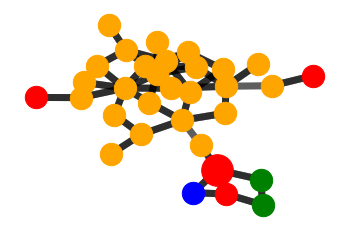

In [18]:
from ExplanationEvaluation.utils.plotting import plot
plot(graph, expl, labels, 400, 12, 100, 'syn1', show=True)

In [ ]:
for idx in indices:
    graph, expl = explainer.explain(idx)
    plot(graph, expl, labels, idx, 12, 100, 'syn1', show=True)

# Evaluating the explainer

In [20]:
from ExplanationEvaluation.datasets.ground_truth_loaders import load_dataset_ground_truth
explanation_labels, indices = load_dataset_ground_truth('syn1')

In [21]:
from ExplanationEvaluation.evaluation.AUCEvaluation import AUCEvaluation
from ExplanationEvaluation.evaluation.EfficiencyEvaluation import EfficiencyEvluation

auc_evaluation = AUCEvaluation(task, explanation_labels, indices)
inference_eval = EfficiencyEvluation()

In [23]:
from ExplanationEvaluation.tasks.replication import run_experiment

auc, time = run_experiment(inference_eval, auc_evaluation, explainer, indices)

100%|██████████| 60/60 [00:02<00:00, 25.98it/s]


In [24]:
print(auc)
print(time)

0.9177562899040008
38.632774353027344


In [ ]:
for idx in indices:
    graph, expl = explainer.explain(idx)
    plot(graph, expl, labels, idx, 12, 100, 'syn1', show=True)

# GNNExplainer from Pytorch Geometric

In [22]:
# Syntetic dataset
graphs, features, labels, _, _, _ = load_dataset('syn1')
explanation_labels, indices = load_dataset_ground_truth('syn1')
edge_index = torch.tensor(graphs)
features = torch.tensor(features)
labels = torch.tensor(labels)
edge_label = torch.tensor(explanation_labels[1])

Loading syn1 dataset


In [ ]:
# dataset = Data(x=features, edge_index=edge_index, y=labels, edge_label = edge_label)
# data = dataset
# #print(data)
# data.train_mask = data.val_mask = data.test_mask = data.y = None
# data = train_test_split_edges(data)

In [ ]:
# Link prediction

import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def forward(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.forward() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.forward() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs



best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Explain node 402: 100%|██████████| 200/200 [00:00<00:00, 483.67it/s]


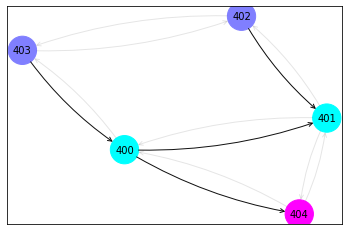

In [ ]:
# node 

import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
import os

# dataset = 'Cora'
# path = path = os.path.join(os.getcwd(), 'data', 'Planetoid')
# dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
# data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
node_idx = 402
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()


In [ ]:
graphs, features, labels, _, _, _ = load_dataset('syn1')
explanation_labels, indices = load_dataset_ground_truth('syn1')
edge_index = torch.tensor(graphs)
features= torch.tensor(features)
labels = torch.tensor(labels)
edge_label = torch.tensor(explanation_labels[1])

Loading syn1 dataset


In [ ]:
from torch_geometric.data import Data
dataset = Data(x=features, edge_index=edge_index, y=labels, edge_label = edge_label, num_classes=4)
data = dataset
print(data)

Data(x=[700, 10], edge_index=[2, 4110], y=[700], edge_label=[4110], num_classes=4)


In [ ]:
# for Node classification 

from sklearn.model_selection import train_test_split
idx = torch.arange(data.num_nodes)
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=data.y)

In [ ]:
# for link prediction
from torch_geometric.utils import train_test_split_edges
data = train_test_split_edges(data)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


#BAShapes GNNExplainer from Pytorch geometric

In [ ]:
from typing import Optional, Callable

import torch
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import barabasi_albert_graph


def house():
    edge_index = torch.tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
                               [1, 3, 4, 4, 2, 0, 1, 3, 2, 0, 0, 1]])
    label = torch.tensor([1, 1, 2, 2, 3])
    return edge_index, label


class BAShapes(InMemoryDataset):
    r"""The BA-Shapes dataset from the `"GNNExplainer: Generating Explanations
    for Graph Neural Networks" <https://arxiv.org/pdf/1903.03894.pdf>`_ paper,
    containing a Barabasi-Albert (BA) graph with 300 nodes and a set of 80
    "house"-structured graphs connected to it.

    Args:
        connection_distribution (string, optional): Specifies how the houses
            and the BA graph get connected. Valid inputs are :obj:`"random"`
            (random BA graph nodes are selected for connection to the houses),
            and :obj:`"uniform"` (uniformly distributed BA graph nodes are
            selected for connection to the houses). (default: :obj:`"random"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
    """
    def __init__(self, connection_distribution: str = "random",
                 transform: Optional[Callable] = None):
        super().__init__('.', transform)
        assert connection_distribution in ['random', 'uniform']

        # Build the Barabasi-Albert graph:
        num_nodes = 300
        edge_index = barabasi_albert_graph(num_nodes, num_edges=5)
        edge_label = torch.zeros(edge_index.size(1), dtype=torch.int64)
        node_label = torch.zeros(num_nodes, dtype=torch.int64)

        # Select nodes to connect shapes:
        num_houses = 80
        if connection_distribution == 'random':
            connecting_nodes = torch.randperm(num_nodes)[:num_houses]
        else:
            step = num_nodes // num_houses
            connecting_nodes = torch.arange(0, num_nodes, step)

        # Connect houses to Barabasi-Albert graph:
        edge_indices = [edge_index]
        edge_labels = [edge_label]
        node_labels = [node_label]
        for i in range(num_houses):
            house_edge_index, house_label = house()

            edge_indices.append(house_edge_index + num_nodes)
            edge_indices.append(
                torch.tensor([[int(connecting_nodes[i]), num_nodes],
                              [num_nodes, int(connecting_nodes[i])]]))

            edge_labels.append(
                torch.ones(house_edge_index.size(1), dtype=torch.long))
            edge_labels.append(torch.zeros(2, dtype=torch.long))

            node_labels.append(house_label)

            num_nodes += 5

        edge_index = torch.cat(edge_indices, dim=1)
        edge_label = torch.cat(edge_labels, dim=0)
        node_label = torch.cat(node_labels, dim=0)

        x = torch.ones((num_nodes, 10), dtype=torch.float)
        expl_mask = torch.zeros(num_nodes, dtype=torch.bool)
        expl_mask[torch.arange(400, num_nodes, 5)] = True

        data = Data(x=x, edge_index=edge_index, y=node_label,
                    expl_mask=expl_mask, edge_label=edge_label)

        self.data, self.slices = self.collate([data])


In [ ]:
from tqdm import tqdm

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

#from torch_geometric.datasets import BAShapes
from torch_geometric.nn import GCN, GNNExplainer
from torch_geometric.utils import k_hop_subgraph
import torch_geometric.transforms as T

dataset = BAShapes(transform=T.GCNNorm())
data = dataset[0]

idx = torch.arange(data.num_nodes)
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=data.y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCN(data.num_node_features, hidden_channels=20, num_layers=3,
            out_channels=dataset.num_classes, normalize=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_weight).argmax(dim=-1)

    train_correct = int((pred[train_idx] == data.y[train_idx]).sum())
    train_acc = train_correct / train_idx.size(0)

    test_correct = int((pred[test_idx] == data.y[test_idx]).sum())
    test_acc = test_correct / test_idx.size(0)

    return train_acc, test_acc


for epoch in range(1, 2001):
    loss = train()
    if epoch % 200 == 0:
        train_acc, test_acc = test()
        print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
targets, preds = [], []
expl = GNNExplainer(model, epochs=300, return_type='raw', log=False)

# Explanation ROC AUC over all test nodes:
self_loop_mask = data.edge_index[0] != data.edge_index[1]
for node_idx in tqdm(data.expl_mask.nonzero(as_tuple=False).view(-1).tolist()):
    _, expl_edge_mask = expl.explain_node(node_idx, data.x, data.edge_index,
                                          edge_weight=data.edge_weight)
    subgraph = k_hop_subgraph(node_idx, num_hops=3, edge_index=data.edge_index)
    expl_edge_mask = expl_edge_mask[self_loop_mask]
    subgraph_edge_mask = subgraph[3][self_loop_mask]
    targets.append(data.edge_label[subgraph_edge_mask].cpu())
    preds.append(expl_edge_mask[subgraph_edge_mask].cpu())

auc = roc_auc_score(torch.cat(targets), torch.cat(preds))
print(f'Mean ROC AUC: {auc:.4f}')

In [ ]:
indices = range(400, 700, 5)

In [ ]:
node_idx = 410# select a node to explain, this needs to be part of the list of indices
#graph, expl = explainer.explain(idx)

In [ ]:
import matplotlib.pyplot as plt

explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
#node_idx = 402
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
plt.show()